# Project - Wine Quality

For this project, we want to develop a classification model for assessed quality of these wines. Rather than treating these scores as a numeric value and using a regression based approach we will discretize the quality data into the following categories: `excellent`, `good`, `average`, `poor`. The categorization must occur using the following table:

| Quality Category  | Quality Score |
|-------------------|:-------------:|
| Excellent         | $\geq 7$      |
| Good              | $6$           |
| Average           | $5$           |
| Poor              | $\leq 4$      |   

The goal is therefore to develop a classification model for correctly identifying the quality category for a wine given its physicochemical characteristics.

## 1. Setup

### 1.1 Libraries

In [1]:
import pkg_resources
if pkg_resources.get_distribution("scikit-learn").version == '0.21.3':
    !pip install --upgrade scikit-learn scipy pandas seaborn

In [2]:
import sys
!{sys.executable} -m pip install imbalanced-learn

In [3]:
# Add any additional libraries or submodules below
#ignore annoying warning
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 80

# ipython interactive widgets
from ipywidgets import interact

# sklearn modules
import sklearn
import sklearn.ensemble 
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

### 1.2 Data

In [4]:
wine_train = pd.read_csv("wine_qual_train.csv")
wine_test  = pd.read_csv("wine_qual_test.csv")

## 2. Exploratory Data Analysis and Preprocessing

### 2.1 Exploratory Data Analysis

In [5]:
wine_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
quality                 3000 non-null int64
wine                    3000 non-null object
fixed_acidity           3000 non-null float64
volatile_acidity        3000 non-null float64
citric_acid             3000 non-null float64
residual_sugar          3000 non-null float64
chlorides               3000 non-null float64
free_sulfur_dioxide     3000 non-null float64
total_sulfur_dioxide    3000 non-null float64
density                 3000 non-null float64
p_h                     3000 non-null float64
sulphates               3000 non-null float64
alcohol                 3000 non-null float64
dtypes: float64(11), int64(1), object(1)
memory usage: 304.8+ KB


In [6]:
print(wine_train.shape)

(3000, 13)


The dataset have 3000 data and 13 features.

In [7]:
Sum = wine_train.isnull().sum()
Percentage = (wine_train.isnull().sum()/wine_train.isnull().count())

pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

,Sum,Percentage
quality,0,0.0
wine,0,0.0
fixed_acidity,0,0.0
volatile_acidity,0,0.0
citric_acid,0,0.0
residual_sugar,0,0.0
chlorides,0,0.0
free_sulfur_dioxide,0,0.0
total_sulfur_dioxide,0,0.0
density,0,0.0


There is no missing data in training dataset

Now, we according wine quality to create `'quality_label'` which is poor, average, good and excellent.

In [8]:
wine_train['quality_label'] = wine_train.quality.apply(lambda q: 'poor' if q <= 4 
                                                       else 'average' if q == 5
                                                       else 'good' if q == 6
                                                       else 'excellent')

In [9]:
cols = wine_train.columns
exs = round(wine_train[wine_train['quality_label'] == 'excellent'][cols].describe(),2)
gos = round(wine_train[wine_train['quality_label'] == 'good'][cols].describe(),2)
avs = round(wine_train[wine_train['quality_label'] == 'average'][cols].describe(),2)
pos = round(wine_train[wine_train['quality_label'] == 'poor'][cols].describe(),2)
pd.concat([exs, gos, avs, pos], axis=0, 
          keys=['Excellent', 'Good', 'Average', 'Poor'])

quality  fixed_acidity  volatile_acidity  citric_acid  \
Excellent count   554.00         554.00            554.00       554.00   
          mean      7.13           7.10              0.29         0.33   
          std       0.35           1.35              0.12         0.11   
          min       7.00           3.90              0.11         0.00   
          25%       7.00           6.30              0.21         0.28   
          50%       7.00           6.90              0.28         0.32   
          75%       7.00           7.40              0.34         0.38   
          max       9.00          15.60              0.92         0.76   
Good      count  1317.00        1317.00           1317.00      1317.00   
          mean      6.00           7.19              0.32         0.33   
          std       0.00           1.33              0.15         0.15   
          min       6.00           4.40              0.10         0.00   
          25%       6.00           6.30              0.22         0.26   
          50%       6.00           6.90              0.27         0.31   
          75%       6.00           7.70              0.37         0.40   
          max       6.00          14.30              1.02         1.66   
Average   count  1019.00        1019.00           1019.00      1019.00   
          mean      5.00           7.34              0.39         0.31   
          std       0.00           1.26              0.18         0.16   
          min       5.00           4.50              0.12         0.00   
          25%       5.00           6.55              0.26         0.22   
          50%       5.00           7.10              0.33         0.30   
          75%       5.00           7.80              0.49         0.41   
          max       5.00          15.90              1.33         1.00   
Poor      count   110.00         110.00            110.00       110.00   
          mean      3.93           7.37              0.45         0.28   
          std       0.26           1.28              0.22         0.19   
          min       3.00           5.50              0.16         0.00   
          25%       4.00           6.50              0.28         0.16   
          50%       4.00           6.95              0.38         0.27   
          75%       4.00           8.07              0.59         0.37   
          max       4.00          12.50              1.13         1.00   

                 residual_sugar  chlorides  free_sulfur_dioxide  \
Excellent count          554.00     554.00               554.00   
          mean             4.95       0.04                31.94   
          std              4.11       0.02                15.49   
          min              0.90       0.01                 3.00   
          25%              1.80       0.03                21.00   
          50%              3.05       0.04                32.00   
          75%              6.70       0.05                40.00   
          max             19.25       0.14               108.00   
Good      count         1317.00    1317.00              1317.00   
          mean             5.63       0.05                31.82   
          std              5.04       0.03                17.52   
          min              0.70       0.02                 1.00   
          25%              1.80       0.04                19.00   
          50%              3.00       0.05                30.00   
          75%              8.60       0.06                43.00   
          max             65.80       0.34               112.00   
Average   count         1019.00    1019.00              1019.00   
          mean             5.88       0.06                30.21   
          std              5.03       0.04                18.68   
          min              0.60       0.01                 3.00   
          25%              1.90       0.04                15.00   
          50%              3.20       0.05                27.00   
          75%              8.75  

Highlights from descriptive statisct of quality perspective above:

* The higher the quality, the higher the average alcohol concentration
* The chlorides and volatile_acidity are less present and presented smaller standard deviation in wines of higher quality.
* The free_sulfur_dioxide is higher with higher quality, but their standard deviation decrease with the increase the quality.
* Higher quality has less fixed_acidity, but the standard deviation slightly increase with the increase the quality.
* Lower levels of volatile_acids in wines with high quality ratings

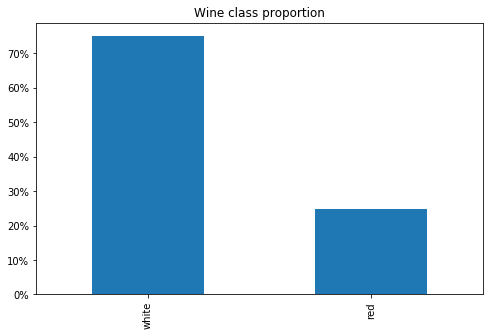

white    0.751333
red      0.248667
Name: wine, dtype: float64


In [10]:
from matplotlib.ticker import PercentFormatter
data = wine_train['wine'].value_counts(normalize=True)
data.plot(kind='bar',figsize=(8,5))
plt.title("Wine class proportion",fontsize= 12)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()
print(data)

We can see that 75.1% data is white wine and 24.9% is red wine.

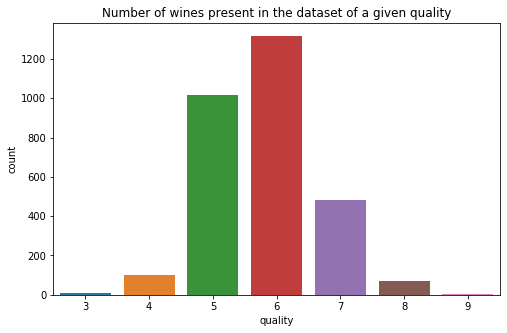

,count
6,1317
5,1019
7,483
4,102
8,69
3,8
9,2


In [11]:
plt.figure(figsize=(8,5))
sns.countplot(x='quality', data=wine_train)
plt.title('Number of wines present in the dataset of a given quality')
plt.show()
quality_count = wine_train['quality'].value_counts()
quality = pd.DataFrame({'count' :quality_count}) 
quality

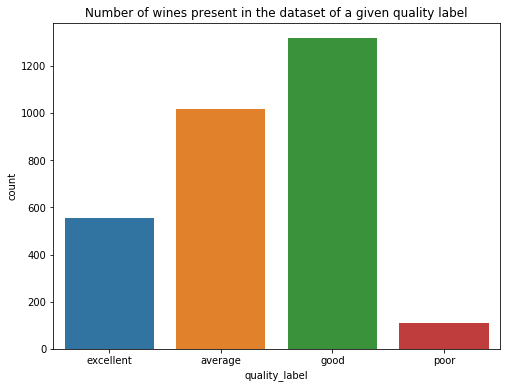

,count
good,1317
average,1019
excellent,554
poor,110


In [12]:
plt.figure(figsize=(8,6))
sns.countplot(x='quality_label', data=wine_train)
plt.title('Number of wines present in the dataset of a given quality label')
plt.show()
quality_class_count = wine_train['quality_label'].value_counts()
quality_class = pd.DataFrame({'count' :quality_class_count}) 
quality_class

From the above count plots, we know that most wine quality label would be good and average.

We create a new variable called `'bonus_sulfur_dioxide'` which is 'total_sulfur_dioxide' - 'free_sulfur_dioxide' because two variable have correlation.

In [13]:
# change white to be 0, red to be 1 and create a new variable
wine_train.wine = wine_train.wine.map({'white':0, 'red':1}) 
wine_train['bonus_sulfur_dioxide'] = wine_train['total_sulfur_dioxide'] - wine_train['free_sulfur_dioxide']

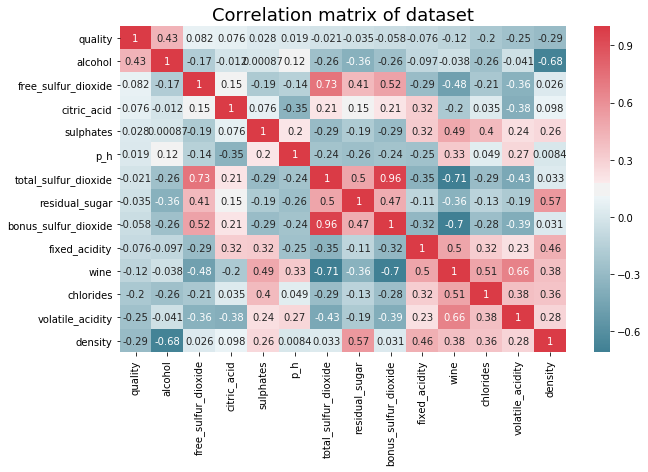

In [14]:
corr = wine_train.corr()
top_corr_cols = corr.quality.sort_values(ascending=False).keys() 
top_corr = corr.loc[top_corr_cols, top_corr_cols]
plt.figure(figsize=(10,6))
plt.title('Correlation matrix of dataset', size = 18)
sns.heatmap(top_corr ,cmap=sns.diverging_palette(220, 10, as_cmap=True),annot=True)

* alcohol show the postive correlation values with wine quality
* chlorides, volatile_acidity and density as a negative correlation with wine quality
* total_sulfur_dioxide and free_sulfur_dioxide have high correlation
* total_sulfur_dioxide and bonus_sulfur_dioxide have high correlation
* total_sulfur_dioxide and wine have high correlation

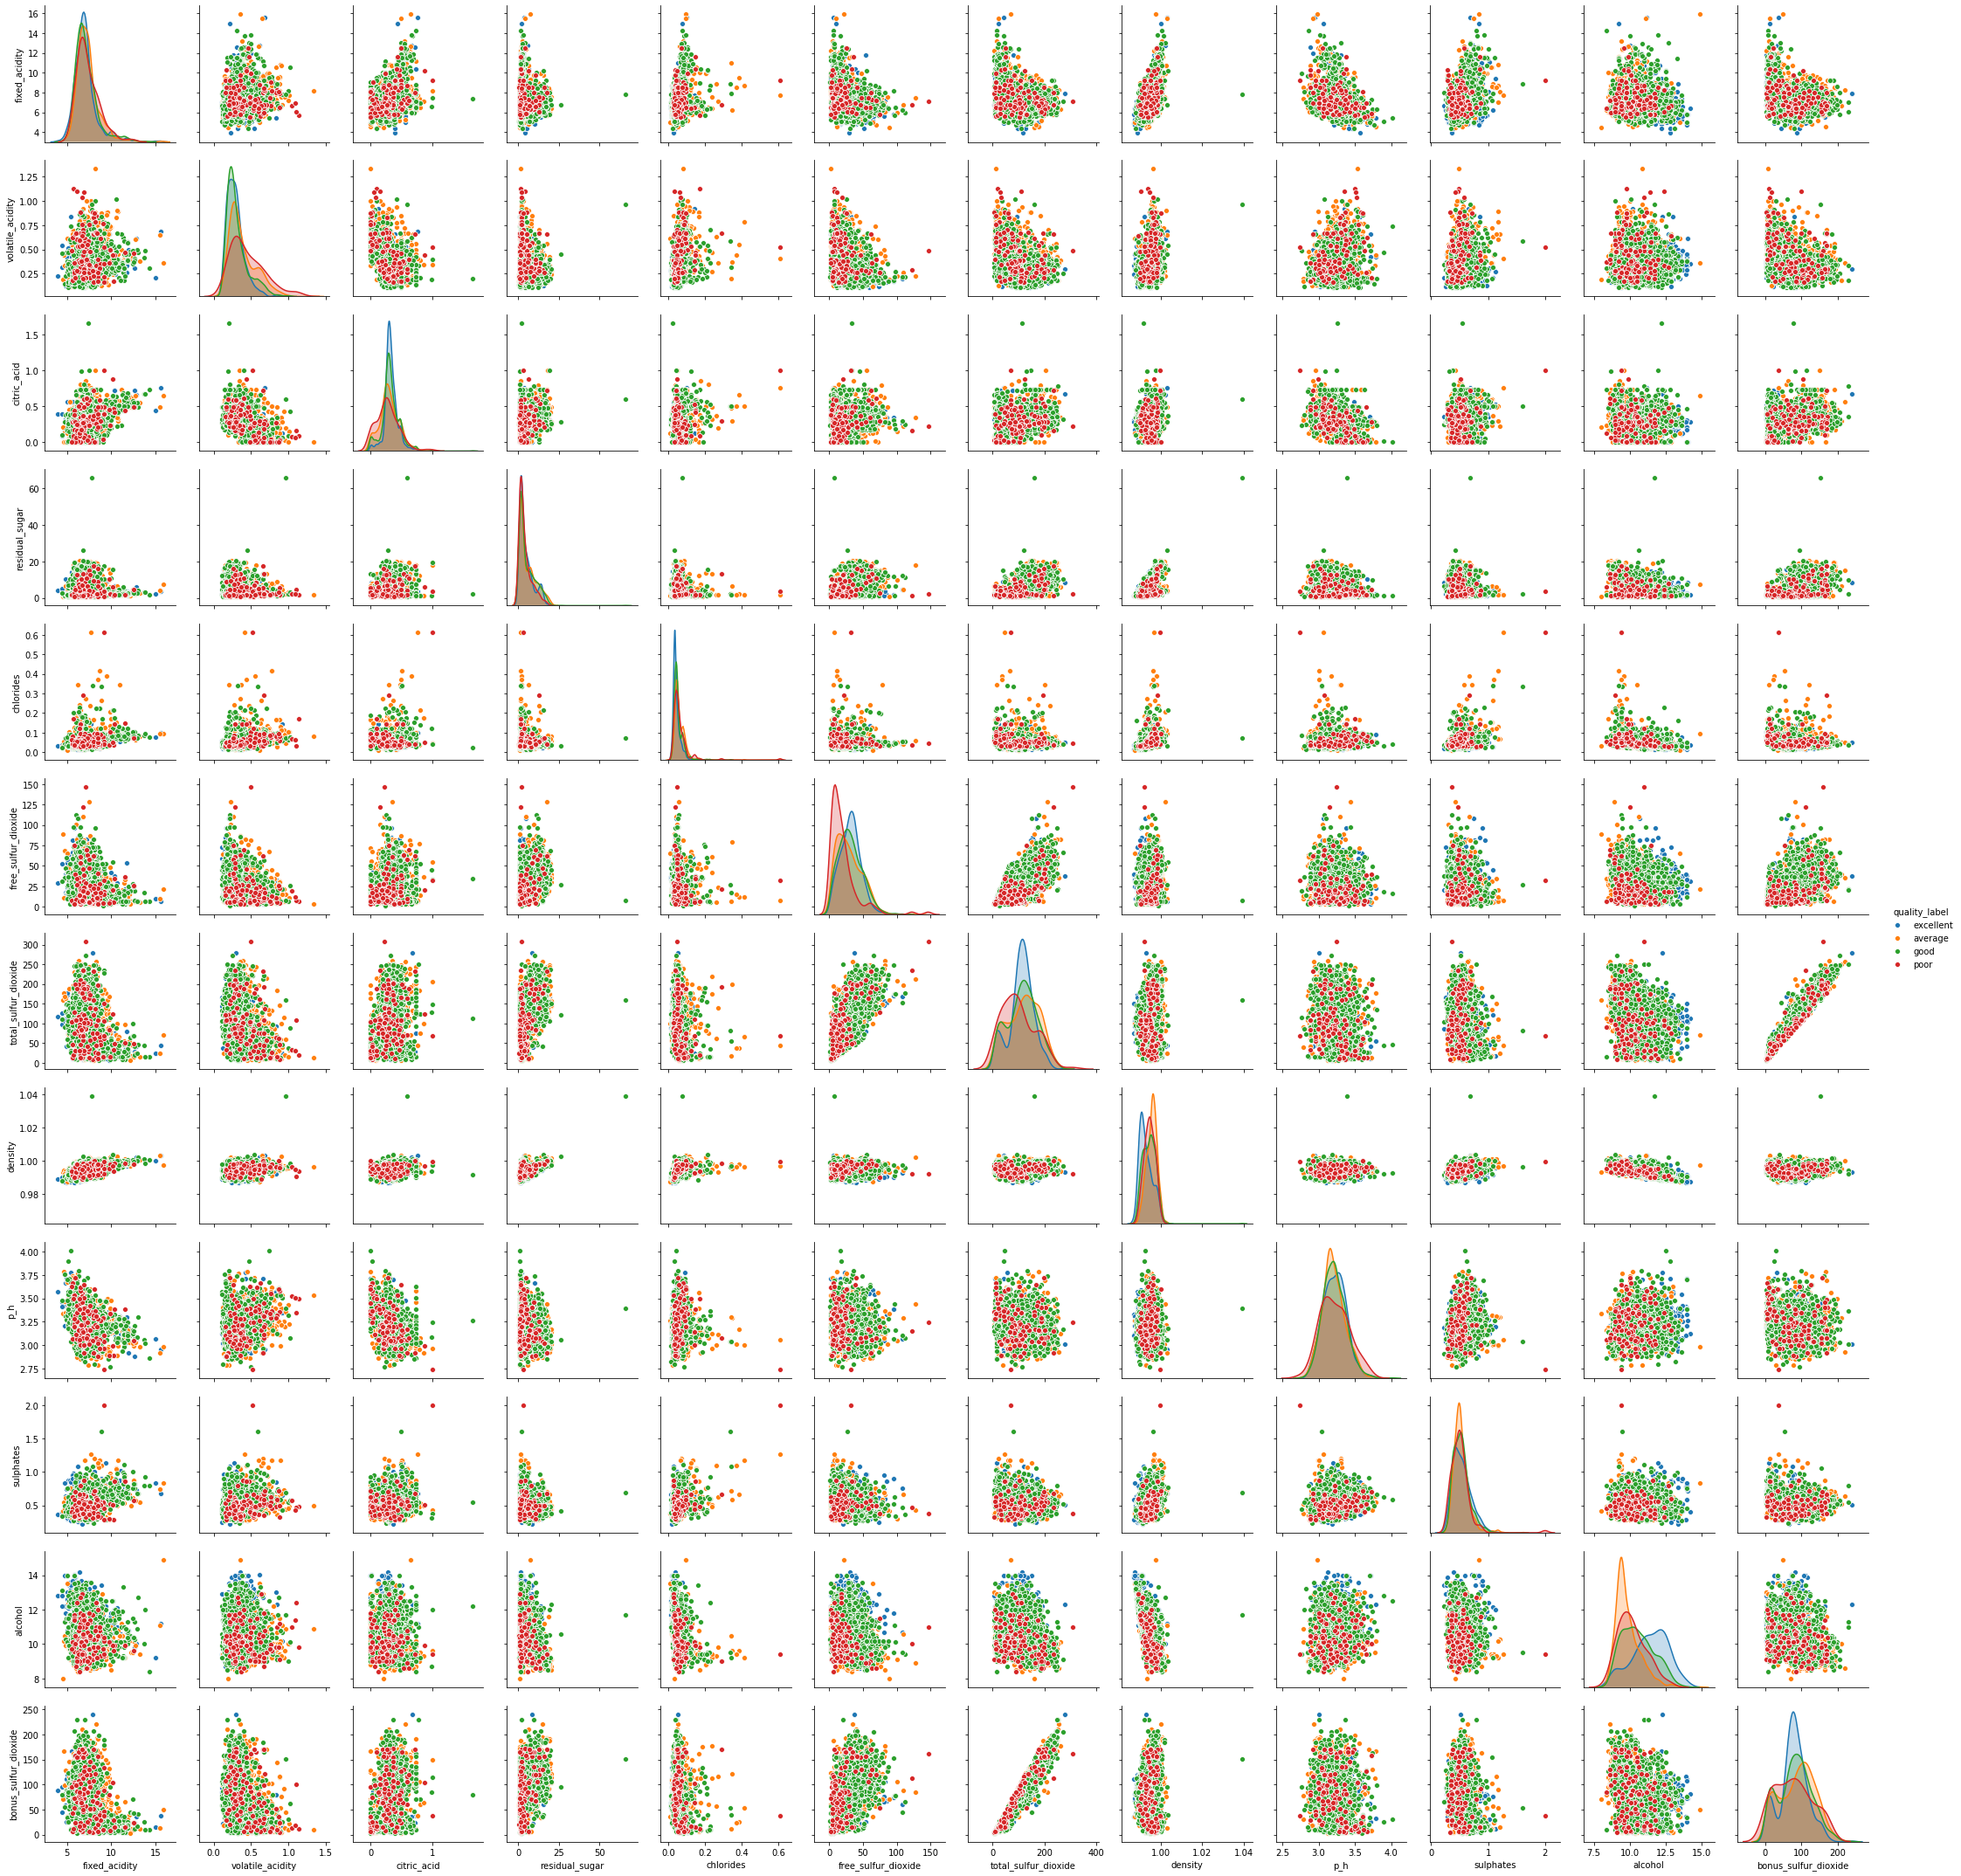

In [15]:
cols = wine_train.columns
cols = list(cols.drop(['quality', 'wine']))
sns.pairplot(data = wine_train.loc[:, cols], hue='quality_label')

We notice the following points regarding wine quality:
* Excellent wines have more percentage of alcohol.
* Poor wines have a bigger volatile_acidity distribution.
* Excellent wines have the least chlorides.
* Excellent wines have the least density.

### 2.2 Processing data

In [16]:
# change the variable wine into White:0, Red:1 
# poor(quality<=4): 0, average(quality=5): 1, good(quality=6): 2, excellent(quality>=7): 3
wine_train.quality = wine_train.quality.apply(lambda q: 0 if q <= 4 
                                              else 1 if q == 5 
                                              else 2 if q == 6 
                                              else 3)
wine_test.quality = wine_test.quality.apply(lambda q: 0 if q <= 4 
                                            else 1 if q == 5 
                                            else 2 if q == 6 
                                            else 3) 
wine_test.wine = wine_test.wine.map({'white':0, 'red':1})
wine_test['bonus_sulfur_dioxide'] = wine_test['total_sulfur_dioxide'] - wine_test['free_sulfur_dioxide']

In [17]:
quality_count = wine_train['quality'].value_counts()
quality = pd.DataFrame({'count' :quality_count}) 
quality

,count
2,1317
1,1019
3,554
0,110


We can see that data is imblanced for quality class.

In order to prevent imblanced data to discard useful information. We resample the data from each quality class for training dataset and process training set and testing set.

In [18]:
cols = wine_train.columns
cols = list(cols.drop(['quality', 'quality_label']))
x_train = wine_train.loc[:, cols]
y_train = pd.DataFrame({'target': wine_train['quality']})
x_test = wine_test.loc[:, cols]
y_test = pd.DataFrame({'target': wine_test['quality']})

In [19]:
ada = ADASYN(random_state=1)
x_train, y_train = ada.fit_sample(x_train, y_train)

print("y_train: ",Counter(y_train['target']),"\n",
      "y_test: ",Counter(y_test['target']))

y_train:  Counter({3: 1376, 2: 1317, 0: 1284, 1: 1132}) 
 y_test:  Counter({2: 429, 1: 325, 3: 202, 0: 44})


## 3. Model Fitting and Tuning

In [20]:
from sklearn.model_selection import train_test_split

# Split the data into training data and validation data
Xt, Xv, yt, yv = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [21]:
# Helpful function for visualizing confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, figsize=(6,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title, size = 16)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

### 3.1. Random Forest

Since we hope the classification can be accurate not only for overall accuracy but also for each class, we try to change the scoring to be `'recall_macro'`. And we use random forest as our algorithm to build model and the select the features.

In [22]:
features = Xt.columns
RF = sklearn.ensemble.RandomForestClassifier(random_state=42)
n_estimators = [int(x) for x in np.linspace(100, 150, num=5)]
max_depth = [int(x) for x in np.linspace(1, 50, num=5)]
max_depth.append(None)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

gs = GridSearchCV(estimator=RF, param_grid=random_grid, scoring='recall_macro', cv=10, verbose=1, n_jobs=-1)
gs.fit(Xt[features], yt)
print(gs.best_params_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.0min finished


{'max_depth': 37, 'n_estimators': 137}


In [23]:
RF_result = yv.copy()
RF_model = sklearn.ensemble.RandomForestClassifier(n_estimators=137, max_depth=37, random_state=42)
RF_model.fit(Xt[features], yt)
RF_result['pred'] = RF_model.predict(Xv[features])
print(sklearn.metrics.classification_report(RF_result.target, RF_result.pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       257
           1       0.69      0.64      0.66       229
           2       0.62      0.55      0.58       264
           3       0.78      0.86      0.82       272

    accuracy                           0.76      1022
   macro avg       0.75      0.76      0.75      1022
weighted avg       0.75      0.76      0.75      1022



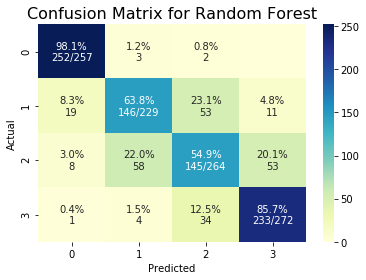

In [24]:
plot_confusion_matrix(RF_result.target, RF_result.pred, title="Confusion Matrix for Random Forest")

### 3.2. Logistic Regression

In [25]:
LG = sklearn.linear_model.LogisticRegression(multi_class = 'multinomial', random_state=42)
penalty = ['l1', 'l2']
C = [x for x in np.logspace(1,5,5)]
dual=[True, False]
max_iter=[100, 500, 1000]

# Create the random grid
random_grid = {
    'penalty':penalty,
    'C': C,
    'dual':dual,
    'max_iter':max_iter
}
gs = GridSearchCV(estimator=LG, param_grid=random_grid, scoring='recall_macro', cv=5, verbose=1, n_jobs=-1)
gs.fit(Xt[features], yt)
print(gs.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   28.3s finished


{'C': 100000.0, 'dual': False, 'max_iter': 1000, 'penalty': 'l2'}


              precision    recall  f1-score   support

           0       0.60      0.66      0.63       257
           1       0.38      0.35      0.37       229
           2       0.39      0.29      0.33       264
           3       0.54      0.67      0.60       272

    accuracy                           0.50      1022
   macro avg       0.48      0.49      0.48      1022
weighted avg       0.48      0.50      0.49      1022



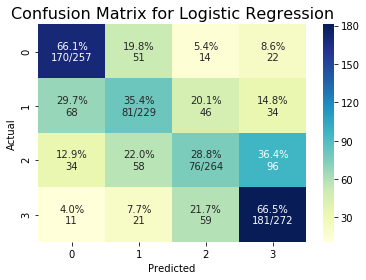

In [26]:
LG_result = yv.copy()
LG_model = sklearn.linear_model.LogisticRegression(C=10000, dual=False, max_iter=1000, 
                                                   penalty='l2', random_state=42)
LG_model.fit(Xt[features], yt)
LG_result['pred'] = LG_model.predict(Xv[features])
print(sklearn.metrics.classification_report(LG_result.target, LG_result.pred))
plot_confusion_matrix(LG_result.target, LG_result.pred, title="Confusion Matrix for Logistic Regression")

### 3.3. Decision Tree

In [27]:
DT = sklearn.tree.DecisionTreeClassifier(random_state=42)
max_depth = [int(x) for x in np.linspace(10, 20, 10, endpoint=True)]

# Create the random grid
random_grid = {
    'max_depth': max_depth
}
gs = GridSearchCV(estimator=DT, param_grid=random_grid, scoring='recall_macro', cv=5, verbose=1, n_jobs=-1)
gs.fit(Xt[features], yt)
print(gs.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'max_depth': 20}


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished


              precision    recall  f1-score   support

           0       0.82      0.87      0.85       257
           1       0.55      0.59      0.57       229
           2       0.50      0.42      0.46       264
           3       0.72      0.74      0.73       272

    accuracy                           0.66      1022
   macro avg       0.65      0.66      0.65      1022
weighted avg       0.65      0.66      0.65      1022



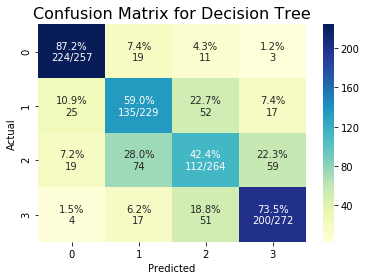

In [28]:
DT_result = yv.copy()
DT_model = sklearn.tree.DecisionTreeClassifier(max_depth=15, random_state=42)
DT_model.fit(Xt[features], yt)
DT_result['pred'] = DT_model.predict(Xv[features])
print(sklearn.metrics.classification_report(DT_result.target, DT_result.pred))
plot_confusion_matrix(DT_result.target, DT_result.pred, title="Confusion Matrix for Decision Tree")

The performance of Random Forest is better than others. We will employ this method as following.

### 3.4. Variables Selection

There are some variables which have high correlation with each other. If we use those vairbles, it may cause multicollinearity. In order to prevent this issue, we use feature importances at first to select variables.

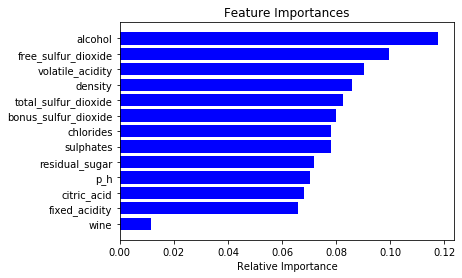

In [29]:
importances = RF_model.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Because the variable of wine has low importance in the model, we decide to remove this feature from the model. The variable of total_sulfur_dioxide have high correlation with free_sulfur_dioxide and bonus_sulfur_dioxide so try to remove this feature from the model to prevent multicolinearity.

In [30]:
features = Xt.columns.drop(['total_sulfur_dioxide', 'wine'], 1)
n_estimators = [int(x) for x in np.linspace(100, 150, num = 5)]
max_depth = [int(x) for x in np.linspace(1, 50, num = 5)]
max_depth.append(None)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

gs = GridSearchCV(estimator=RF, param_grid=random_grid, scoring='recall_macro', cv=10, verbose=1, n_jobs=-1)
final_model = gs.fit(Xt[features], yt)
print(gs.best_params_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.5min finished


{'max_depth': 37, 'n_estimators': 137}


In [31]:
RF_result_2 = yv.copy()
RF_model_2 = sklearn.ensemble.RandomForestClassifier(n_estimators=137, max_depth=37, random_state=42)
RF_model_2.fit(Xt[features], yt)
RF_result_2['pred'] = RF_model_2.predict(Xv[features])
print(sklearn.metrics.classification_report(RF_result_2.target, RF_result_2.pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       257
           1       0.70      0.65      0.67       229
           2       0.60      0.51      0.55       264
           3       0.77      0.85      0.81       272

    accuracy                           0.75      1022
   macro avg       0.74      0.75      0.74      1022
weighted avg       0.74      0.75      0.74      1022



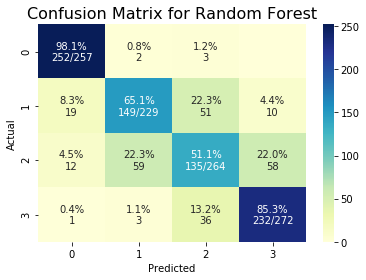

In [32]:
plot_confusion_matrix(RF_result_2.target, RF_result_2.pred, title="Confusion Matrix for Random Forest")

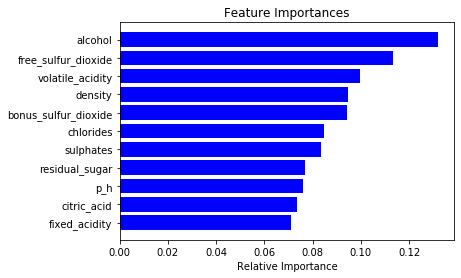

In [33]:
importances = RF_model_2.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We can see that the importances of each variables are quite similar. Also, the result of confusion matrix presents not bad.

## 4. Discussion


From the exploratory data analysis, we can know that `'alcohol'`, `'chlorides'`, `'density'` and `'citric_acid'` have high correlation with quality. Also, we can see that `'free_sulfur_dioxide'` and `'total_sulfur_dioxide'` have high correlation. We create a feature `'bonus_sulfur_dioxide'` which is `'total_sulfur_dioxide'` subtract `'free_sulfur_dioxide'`. Then we can see the influence of `'free_sulfur_dioxide'` and the rest of sulfur dioxide. After that, we decide to omit `'wine'` according to the coefficient importance in the model and `'total_sulfur_dioxide'` to prevent multicolinearity.

Therefore we take the features including `'fixed_acidity'`, `'volatile_acidity'`, `'citric_acid'`, `'residual_sugar'`, `'chlorides'`, `'free_sulfur_dioxide'`, `'density'`, `'p_h'`, `'sulphates'`, `'alcohol'` and `'bonus_sulfur_dioxide'`. We use random forest as our algorithm to construct the model.

We use number to represent quality class (poor: 0, average: 1, good: 2, excellent: 3)
The performance of the testing dataset as following, we can see that for classifing average, good and excellent the accuracy is more than 50%. In terms of poor, though wine may be misclassfied, most of them would be average and good. Maybe we can try other technique to improve the accuracy such as deep learning.

In [34]:
features = Xt.columns.drop(['total_sulfur_dioxide', 'wine'], 1)
test_result = y_test.copy()
test_result['pred'] = RF_model_2.predict(x_test[features])
print(sklearn.metrics.classification_report(test_result.target, test_result.pred))

              precision    recall  f1-score   support

           0       0.24      0.34      0.28        44
           1       0.67      0.66      0.66       325
           2       0.61      0.55      0.58       429
           3       0.56      0.63      0.60       202

    accuracy                           0.60      1000
   macro avg       0.52      0.55      0.53      1000
weighted avg       0.60      0.60      0.60      1000



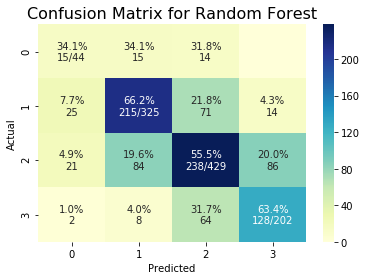

In [35]:
plot_confusion_matrix(test_result.target, test_result.pred, title="Confusion Matrix for Random Forest")